In [1]:
from functools import partial
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from PIL import Image, ImageChops

In [2]:
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)
    else:
        raise Warning('no bbox; image not cropped')
        return im

In [289]:
#: plotting functions
FONTSIZE = 24  # fontsize(30) with figsize(20, 10); fontsize(24) with figsize(16, 8)
FIGSIZE = (16, 8)
dashed_line = partial(plt.plot, color='black', linestyle='--', linewidth=3)
highlight_line = partial(plt.plot, color='black', linestyle='-', linewidth=9)
text_plot = partial(plt.text, fontweight=100, fontsize=FONTSIZE)
vert_text = partial(text_plot, rotation=90, horizontalalignment='right', verticalalignment='center')
horz_text = partial(text_plot, horizontalalignment='center', verticalalignment='bottom')

def square_text(xy, s, **kwargs):
    x, y = xy
    text_plot(x + 0.5, y + 0.5, s, horizontalalignment='center', verticalalignment='center', **kwargs)
    return None
    

def square_plot(xy, val, color, **kwargs):
    square = plt.Rectangle(xy, facecolor=color, 
                           width=1, height=1, edgecolor='black', linewidth=3, **kwargs)
    plt.gca().add_patch(square)
    square_text(xy, str(val))
    return None
    

def highlight_plot(xy, color, alpha=1, width=1, height=1, **kwargs):
    rect = plt.Rectangle(xy, facecolor=color, alpha=alpha, width=width, height=height, 
                         edgecolor='black', linewidth=9, **kwargs)
    plt.gca().add_patch(rect)
    return None


def dashed_grid(width, height):
    for i in range(height + 1):
        dashed_line([0, width], [i, i])
    for j in range(width + 1):
        dashed_line([j, j], [0, height])
    return None

        
def fill_coo_array(mtrx, color):
    coo = sparse.coo_matrix(mtrx)
    h, w = coo.shape
    for x, y, val in zip(coo.col, coo.row, coo.data):
        xy = (x, (h - y - 1))
        square_plot(xy, val, color)
    return None
        

def format_graph(sparse_mtrx, fontsize, offset_y=0):
    h, w = sparse_mtrx.shape
    title = sparse_mtrx.format.upper()
    text_plot((w + 1), (h + 0.1 + offset_y), title, verticalalignment='bottom', fontsize=(fontsize * 3))
    plt.text(0, -0.5, '© Matt Eding')
    plt.axis('equal')
    plt.axis('off')
    return None


def save_step(filename, step, clear=True):
    plt.savefig(f'{filename}_{step:0>5}.png')
    if clear:
        plt.close()  # free memory
    return None


def make_gif(filename, duration, start_extra=0, end_extra=0, crop=False):
    cwd = Path.cwd()
    paths = sorted(p for p in cwd.iterdir() if 'png' in p.suffix)

    if crop:
        imgs = [trim(Image.open(p)) for p in paths]
    else:
        imgs = [Image.open(p) for p in paths]

    for _ in range(start_extra):
        imgs.insert(0, imgs[0])
        
    for _ in range(end_extra):
        imgs.append(imgs[-1])
        
    imgs[0].save(f'{filename}.gif', save_all=True, append_images=imgs, duration=duration, loop=0)
    
    for p in paths:
        p.unlink()
    
    return None

# Sparse vs Dense

In [200]:
def sparse_dense_plot(mtrx, color, duration, filename='sparse_dense', fontsize=FONTSIZE, figsize=FIGSIZE):
    plt.figure(figsize=figsize)
    h, w = mtrx.shape
    step_counter = itertools.count()
    
    def plot_static_img():
        plt.figure(figsize=figsize)

        #: fill sparse format
        dashed_grid(w, h)
        fill_coo_array(mtrx, color)

        #: fill dense format
        for y, row in enumerate(mtrx):
            for x, val in enumerate(row):
                xy = ((w + x + 1), (h - y - 1))
                square_plot(xy, val, color)
        
        text_plot((w / 2), (h + 0.1), 's  p  a  r  s  e', ha='center', va='bottom', fontsize=(fontsize * 3), fontfamily='cursive')
        text_plot((1.5 * w + 1), (h + 0.1), 'DENSE', ha='center', va='bottom', fontsize=(fontsize * 3), fontweight='black')
        plt.text(0, -0.5, '© Matt Eding')
        plt.axis('equal')
        plt.axis('off')
        return None
    
    
    #: highlight animations
    mx = 0.5
    ls = np.logspace(1, 0, 10)  # smooth fadeaway to be less jarring
    ls -= ls.min()
    ls /= ls.max()
    ls *= mx
    for alpha in np.r_[0:mx:10j, [mx] * 20, ls]:
        plot_static_img()
        for y, row in enumerate(mtrx):
            for x, val in enumerate(row):
                if not val:
                    xy = (x, (h - y - 1))
                    square_text(xy, str(val), alpha=alpha)
                    
                    xy = ((w + x + 1), (h - y - 1))
                    highlight_plot(xy, 'none', alpha=alpha*2)
                    
        save_step(filename, next(step_counter))
        
    make_gif(filename, duration, start_extra=20)

In [202]:
mtrx = (sparse.random(5, 7, density=0.4, random_state=123) * 10).astype(int).toarray()
sparse_dense_plot(mtrx, 'darkturquoise', 100)

<Figure size 1152x576 with 0 Axes>

# COO

In [142]:
def coo_plot(mtrx, darkcolor, lightcolor, duration, filename='coo', fontsize=FONTSIZE, figsize=FIGSIZE):
    plt.figure(figsize=figsize)
    coo = sparse.coo_matrix(mtrx)
    h, w = coo.shape
    step_counter = itertools.count()
    
    def plot_static_img():
        plt.figure(figsize=figsize)
        dashed_grid(w, h)
        fill_coo_array(coo, lightcolor)

        #: fill sparse format
        for i, (label, info) in enumerate(zip(['Row', 'Column', 'Data'], [coo.row, coo.col, coo.data])):
            text_plot((w + 1), (h - 0.75 - 2 * i), label)
            for j, val in enumerate(info):
                xy = ((w + j + 1), (h - 2 * (i + 1)))
                square_plot(xy, val, lightcolor)

        #: side labels
        vert_text(-1, (h / 2), 'Row')
        for i in reversed(range(h)):
            vert_text(0, (h - i - 0.5), str(i))

        horz_text((w / 2), (h + 1), 'Column')
        for i in range(w):
            horz_text(i + 0.5, h, str(i))
            
        format_graph(coo, fontsize)
        return None
    

    #: animate highlights
    for i, (r, c) in enumerate(zip(coo.row, coo.col)):
        for alpha in np.r_[0:1:10j, [1] * 10, 1:0:10j]:
            plot_static_img()
            for j in range(3):
                xy = ((w + i + 1), (h - 2 * (j + 1)))
                highlight_plot(xy, darkcolor, alpha)  # sparse part

            xy = (c, (h - r - 1))
            highlight_plot(xy, darkcolor, alpha)  # array part
            
            highlight_line([0, c], [h - r - 0.5] * 2, alpha=alpha)  # horz line
            highlight_line([c + 0.5] * 2, [h - r, h], alpha=alpha)  # vert line
            
            save_step(filename, next(step_counter))
    
    make_gif(filename, duration, start_extra=10)

In [132]:
row = [1, 3, 0, 2, 4]
col = [1, 4, 2, 3, 3]
data = [2, 5, 9, 1, 6]
coo = sparse.coo_matrix((data, (row, col)), shape=(6, 7))
coo_plot(coo, darkcolor='orchid', lightcolor='plum', duration=100)

<Figure size 1152x576 with 0 Axes>

# LIL

In [304]:
def lil_plot(mtrx, darkcolor, lightcolor, duration, filename='lil', fontsize=FONTSIZE, figsize=FIGSIZE):
    plt.figure(figsize=figsize)
    lil = sparse.lil_matrix(mtrx)
    h, w = lil.shape
    step_counter = itertools.count()
    
    def plot_static_img():
        plt.figure(figsize=figsize)
        dashed_grid(w, h)
        fill_coo_array(lil, lightcolor)

        #: fill sparse format
        rowlen = len(max(lil.data, key=len)) + 1
        for i, (label, info) in enumerate(zip(['Rows', 'Data'], [lil.rows, lil.data])):
            
            text_plot((w + 1 + rowlen * (i)), (h - 0.75 + 1), label)
            print(i, info)
            for y, row in enumerate(info):
                for x, val in enumerate(row):
                    xy = ((w + x + 1 + rowlen * (i)), (h - y - 1))
                    square_plot(xy, val, lightcolor)
                    
        #: side labels
        vert_text(-1, (h / 2), 'Row')
        for i in reversed(range(h)):
            vert_text(0, (h - i - 0.5), str(i))

        horz_text((w / 2), (h + 1), 'Column')
        for i in range(w):
            horz_text(i + 0.5, h, str(i))
            
        format_graph(lil, fontsize, offset_y=1)
        return None
    
    
    plot_static_img()

0 [list([0, 2, 4]) list([1, 2]) list([2]) list([0, 2, 3, 4]) list([2, 4])
 list([2])]
1 [list([8, 1, -1]) list([8, 2]) list([3]) list([-2, 4, 8, -2]) list([5, 8])
 list([6])]


<Figure size 1152x576 with 0 Axes>

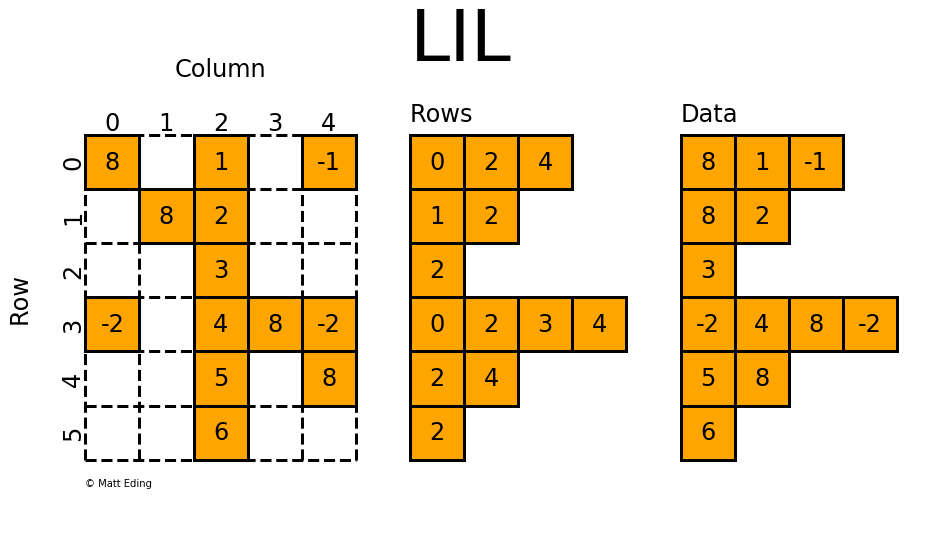

In [312]:
h, w = 6, 5
lil = sparse.lil_matrix((h, w), dtype=int)
lil[(0, -1)] = -1  # set individual point
lil[3, (0, -1)] = np.ones(2) - 3  # set two points
lil.setdiag(8)  # set main diagonal
lil[:, 2] = np.arange(h)[:, np.newaxis] + 1  # set column
lil_plot(lil, 'red', 'orange', 100)

In [ ]:
# print(repr(lil.data), end='\n\n')
# print(repr(lil.rows), end='\n\n')
# print(repr(lil.toarray()))

# CSR

In [133]:
def csr_plot(mtrx, darkcolor, lightcolor, duration, filename='csr', fontsize=FONTSIZE, figsize=FIGSIZE):
    plt.figure(figsize=figsize)
    csr = sparse.csr_matrix(mtrx)
    h, w = csr.shape
    step_counter = itertools.count()
    
    def plot_static_img():
        plt.figure(figsize=figsize)
        dashed_grid(w, h)
        fill_coo_array(csr, lightcolor)
        
        #: fill sparse format
        text_plot((w + 1), (h - 0.75), 'Index Pointers')
        for j, val in enumerate(csr.indptr):
            xy = ((w + j + 1), (h - 2))
            square_plot(xy, val, lightcolor)
                
        for i, (label, info) in enumerate(zip(['Indices', 'Data'], [csr.indices, csr.data])):
            text_plot((w + 1), (h - 0.75 - 2 * i - 3), label)
            for j, val in enumerate(info):
                xy = ((w + j + 1), (h - 2 * (i + 1)) - 3)
                square_plot(xy, val, lightcolor)
        
        #: side labels
        vert_text(-1, (h / 2), 'Pointer')
        for i in reversed(range(h)):
            vert_text(0, (h - i - 0.5), str(i))
        
        horz_text((w / 2), (h + 1), 'Index')
        for i in range(w):
            horz_text(i + 0.5, h, str(i))
        
        format_graph(csr, fontsize)
        return None
        
        
    def highlight_dashed_dotted(alpha=1):
        plot_static_img()
        xy = np.array([(w + 1 + i), (h - 2)])
        highlight_plot(xy, darkcolor, alpha=alpha, width=2)  # pointer
        square_text(xy + [0.5, -1], f'Row: {i}', ha='center', fontsize=(fontsize / 2), alpha=alpha)
        square_text(xy + [0.5, -1.5], f'NNZ: {size}', ha='center', fontsize=(fontsize / 2), alpha=alpha)

        xy = (0, (h - i - 1))
        highlight_plot(xy, color='none', alpha=alpha, width=w, linestyle='-.')  # array row

        for n in range(2):
            xy = np.array([(w + 1 + pos), (h - 2 * (n + 2) - 1)])
            ls = '-.' if size else ':'
            highlight_plot(xy, color='none', alpha=alpha, width=size, linestyle=ls)  # indices and data group
        return None
    
    
    plot_static_img()
    save_step(filename, next(step_counter))
        
    #: animate highlights
    alphas = np.r_[0:1:10j, [1] * 10, 1:0:10j]
    pos = 0
    for i, (ptr_l, ptr_r) in enumerate(zip(csr.indptr, csr.indptr[1:])):
        size = ptr_r - ptr_l
        indices = csr.indices[pos:pos + size]
    
        for alpha in alphas[:alphas.size // 3 * 2]:
            highlight_dashed_dotted(alpha)
            save_step(filename, next(step_counter))
        
        for m, idx in enumerate(indices):
            for alpha in alphas:
                highlight_dashed_dotted(alpha=1)
                for n in range(2):
                    xy = np.array([(w + 1 + pos), (h - 2 * (n + 2) - 1)])
                    highlight_plot(xy + [m, 0], darkcolor, alpha)  # index and datum element
                    highlight_plot([idx, h - i - 1], darkcolor, alpha)  # array element part
                highlight_line([idx + 0.5] * 2, [h - i, h], alpha=alpha)  # vert line
                save_step(filename, next(step_counter))
                
        for alpha in alphas[alphas.size // 3:]:
            highlight_dashed_dotted(alpha)
            save_step(filename, next(step_counter))
                    
        pos += size
        
    make_gif(filename, duration, start_extra=20)

In [134]:
indptr = np.array([0, 2, 3, 3, 3, 6, 6, 7])
indices = np.array([0, 2, 2, 2, 3, 4, 3])
data = np.array([8, 2, 5, 7, 1, 2, 9])
csr = sparse.csr_matrix((data, indices, indptr))
csr_plot(csr, darkcolor='#EE7600', lightcolor='orange', duration=75)

<Figure size 1152x576 with 0 Axes>

# DIA

In [135]:
def dia_plot(mtrx, darkcolor, lightcolor, duration, filename='dia', fontsize=FONTSIZE, figsize=FIGSIZE):
    plt.figure(figsize=figsize)
    dia = sparse.dia_matrix(mtrx)
    h, w = dia.shape
    step_counter = itertools.count()
    
    def plot_static_img():
        plt.figure(figsize=figsize)
        dashed_grid(w, h)
        fill_coo_array(dia, lightcolor)

        #: fill sparse format
        text_plot((w + 1), (h - 0.75), 'Offsets')  # offsets
        for i, (val) in enumerate(dia.offsets):
            xy = ((w + i + 1), (h - 2))
            square_plot(xy, val, lightcolor)
        
        text_plot((w + 1), (h - 2.75), 'Data')  # data
        for i, row in enumerate(dia.data):
            for j, val in enumerate(row):
                xy = ((w + j + 1), (h - i - 4))
                square_plot(xy, val, lightcolor)
        
        #: side labels
        vert_text(-1, (h / 2), '− ⟵ Offset')  # unicode minus sign
        horz_text((w / 2), (h + 1), 'Offset ⟶ +')
        
        format_graph(dia, fontsize)
        return None
        
    
    #: animate highlights
    dur = 10
    data = dia.tocoo().todia().data  # reformat dia.data to have falsy values where excess data
    lex = np.lexsort(dia.offsets[np.newaxis])  # new data did not preserve order
    for i, (offset, d_row) in enumerate(zip(dia.offsets, data[lex])):
        signed_zero = 0.0 * np.sign(offset)
        amount = abs(offset) + 1
        linspace = np.linspace(signed_zero, offset, amount)
        offs = np.r_[[np.nan] * dur, np.repeat(linspace, dur / 2), [offset] * 2 * dur]
        alphas = np.r_[[1] * (len(offs) - dur), 1:0:complex(dur)]

        for off, alpha in zip(offs, alphas):
            plot_static_img()
            
            #: unhighlighted
            if np.isnan(off):
                save_step(filename, next(step_counter))
                continue
            
            #: highlight offset
            xy = ((w + i + 1), (h - 2))
            highlight_plot(xy, darkcolor, alpha)

            #: highlight data
            for j, val in enumerate(d_row):
                xy = ((w + j + 1), (h - i - 4))
                color = darkcolor if val else 'none'
                highlight_plot(xy, color, alpha)

            #: highlight diagonals
            coo = sparse.eye(*dia.shape, k=int(off), dtype=dia.dtype).tocoo()
            for x, y, val in zip(coo.col, coo.row, coo.data):
                xy = (x, (h - y - 1))
                color = darkcolor if (off == offset) else 'none'
                highlight_plot(xy, color, alpha)
                
            #: side labeling for offset
            if offset <= 0:
                xy = (-0.6, (h + off))  # label on side
            else:
                xy = ((off - 0.6), h)  # label on top
            s = f'{off:+0.0f}'
            square_text(xy, s, alpha=alpha, fontweight=1000, 
                        ha='right', va='top')  # using ha/va to avoid functools.partial conflicts
        
            save_step(filename, next(step_counter))

    make_gif(filename, duration, start_extra=8)

In [136]:
data = np.arange(15).reshape(3, -1) + 1
offsets = np.array([0, -3, 2])
dia = sparse.dia_matrix((data, offsets), shape=(7, 5))
dia_plot(dia, 'darkkhaki', 'khaki', duration=100)

<Figure size 1152x576 with 0 Axes>